## Question

I was trying to answer this basic random walk question (similar to the gambler's ruin problem) and thought it will be interesting to do it theorically then with simulations:

On any given day, a stock has 70% chance of increasing by 1 USD, and a 30% chance of decreasing by 1 USD. What are the odds that the stock reaches a 15 USD profit before reaching a 10 USD loss?

### Solution (Gambler's Ruin Formula)

This is a standard result from a one-dimensional (biased) random walk.

The process is *Markovian*, the probability $u_i$ satisfies the recurrence relation based on the outcomes of the next step.

So for any state $i$ such that $1 \leq i \leq N -1$ we have:

$u_i = pu_{i+1} + qu_{i-1}$

To resolve such a linear homogeneous recurrence, we often search a solution liek $u_i = r^i$

In our case we will have $r^i = qr^{i+1} - pr^{i-1}$

We devide by $r^{i-1}$:

$r = pr^2 + q$

This equation has 2 solutions : $r = 1$ or $r = \frac{q}{p}$

Since the recurrence is linear and second order, the general solution is a linear combination od the two independent solutions:

$u_i = A.1^i + B.(\frac{q}{p})^i$

In borders we have:

$i = 0$:

$u_0 = A + B$ thus $A = -B$

$i = N$ :

$u_N = -B + B(\frac{q}{p})^N = B((\frac{q}{p})^N -1) = 1$

so $B = \frac{1}{(\frac{q}{p})^N - 1}$ and $A = - \frac{1}{(\frac{q}{p})^N - 1}$

Replacing this in the equation we will have:

$u_i = - \frac{1}{(\frac{q}{p})^N - 1} + \frac{1}{(\frac{q}{p})^N -1}(\frac{q}{p})^i$

Finally we will have : *$u_i = \frac{1 - (\frac{q}{p})^i}{1 - (\frac{q}{p})^N}$*


#### Now back to our problem

In our case the lower boundary is (-10) and the upper boundary is (+15) (correspond to +25 in this scale) so the starting point is 10:

$P(hit~ 25~ before~ 0) = \frac{1 - (\frac{q}{p})^{10}}{1 -(\frac{q}{p})^{25}}$

After numerator comptation we find that $P(hit~ 25~ before~ 0) \approx 0.9998$


### Simulation

To make sure of our calculations we will simulate this problem:

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


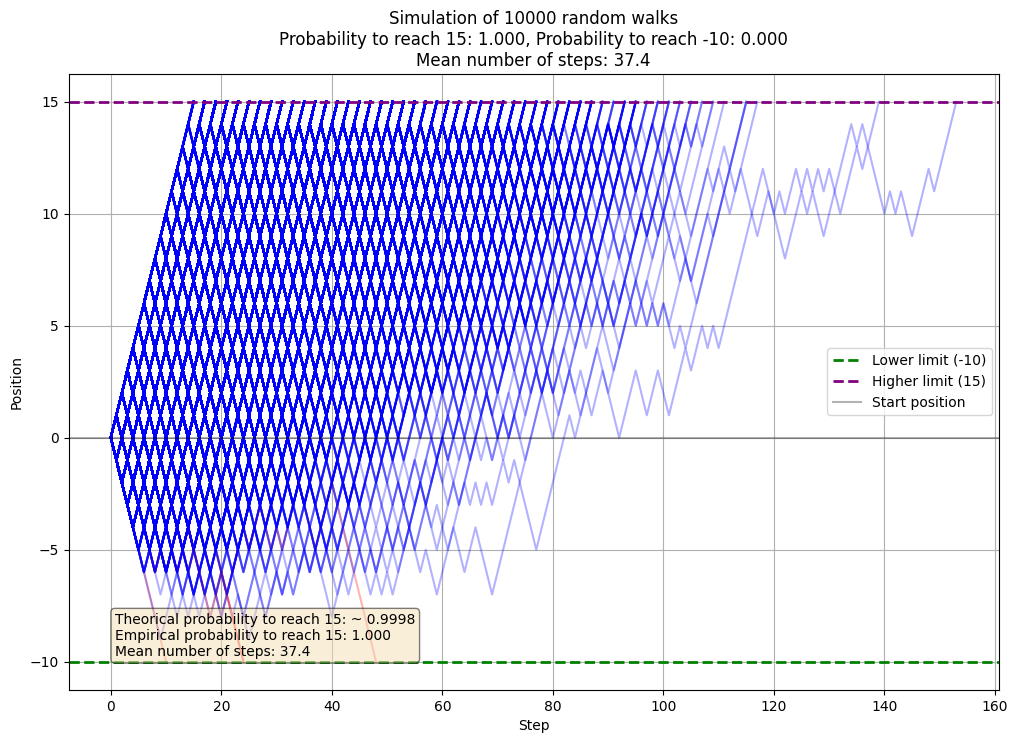

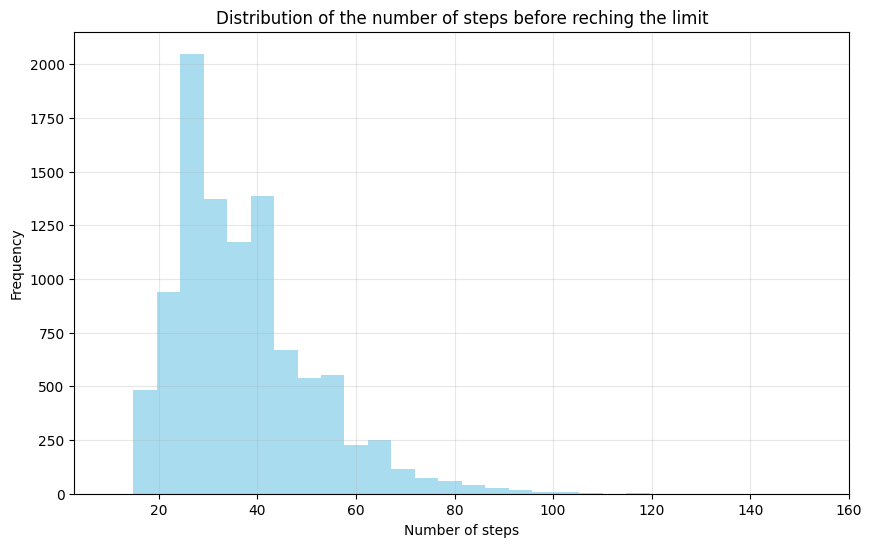

Probability to reach 15: 1.000
Probability to reach -10: 0.000
Mean number of steps: 37.4


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
start = 0
lower_limit = -10
upper_limit = 15
prob_up = 0.7
prob_down = 0.3
num_simulations = 10000


reached_upper = 0
reached_lower = 0
steps_count = []

plt.figure(figsize=(12, 8))


for sim in range(num_simulations):
    # Simulation
    position = start
    positions = [position]  # Track all positions for plotting

    while lower_limit < position < upper_limit:
        move = 1 if np.random.binomial(1, prob_up) == 1 else -1
        position += move
        positions.append(position)

    if position >= upper_limit:
        reached_upper += 1
        color = 'blue'
    else:
        reached_lower += 1
        color = 'red'

    steps_count.append(len(positions)-1)

    plt.plot(positions, alpha=0.3, color=color)

plt.axhline(y=lower_limit, color='green', linestyle='--', linewidth=2, label=f'Lower limit ({lower_limit})')
plt.axhline(y=upper_limit, color='purple', linestyle='--', linewidth=2, label=f'Higher limit ({upper_limit})')
plt.axhline(y=start, color='black', linestyle='-', alpha=0.3, label='Start position')


prob_upper = reached_upper / num_simulations
prob_lower = reached_lower / num_simulations
avg_steps = sum(steps_count) / len(steps_count)

plt.title(f'Simulation of {num_simulations} random walks\n'
          f'Probability to reach {upper_limit}: {prob_upper:.3f}, '
          f'Probability to reach {lower_limit}: {prob_lower:.3f}\n'
          f'Mean number of steps: {avg_steps:.1f}')
plt.xlabel('Step')
plt.ylabel('Position')
plt.legend()
plt.grid(True)


textstr = f'Theorical probability to reach {upper_limit}: ~ 0.9998\n' \
          f'Empirical probability to reach {upper_limit}: {prob_upper:.3f}\n' \
          f'Mean number of steps: {avg_steps:.1f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.05, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='bottom', bbox=props)

plt.show()

# Afficher un histogramme du nombre d'étapes
plt.figure(figsize=(10, 6))
plt.hist(steps_count, bins=30, alpha=0.7, color='skyblue')
plt.title('Distribution of the number of steps before reching the limit')
plt.xlabel('Number of steps')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Probability to reach {upper_limit}: {prob_upper:.3f}")
print(f"Probability to reach {lower_limit}: {prob_lower:.3f}")
print(f"Mean number of steps: {avg_steps:.1f}")

### From Gambler to Portfolio

That's interesting, but if it was that easy then everybody will be rich. Let's try to see this in a more real world problem.

Let's suppose that we have a portfolio that we want to estimate its probability of ruin. We are talking of the probabiity that the portfolio's value will drop below a critical thereshold.

#### Little bit of maths again

We will model our portfolio as evolving in discrete time steps.

At each step $t$ the return $r_t$ is drawn randomly from a distribution. The portfolio value is modeled :
$ V_{t+1} = V_t \times (1 + r_t) $

We will track if the value $V_t$ falls below the threshold $V_{min}$

We will use random returns drawn from a normal distribution and then estimate the ruin using Monte Carlo.


In [11]:
# function to estimate one portfolio path

def simulate_portfolio(initial, mu, sigma, n):
    """
    A function to simulate the portfolio value.
    initial : the initial value of the portfolio
    mu: the mean (mean daily return)
    sigma : the standard deviation (daily volatility)
    n : number of time steps (number of days of trading)
    """
    v = [initial]
    for t in range(n):
        rt = np.random.normal(mu, sigma)
        v.append(v[-1]*(1 + rt))
    return v

In [12]:
# simulate the estimation

def estimate_portfolio_ruin(initial, mu, sigma, threshold, n_steps, n_sims):
    """
    A function to estimate the ruin's probability using Monte Carlo
    initial : the initial value of the portfolio
    mu: the mean (mean daily return)
    sigma : the standard deviation (daily volatility)
    threshold : the threshold value
    n_steps : number of time steps (number of days of trading)
    n_sims : number of simulations
    """
    c = 0
    paths = []
    ruin = threshold*initial
    for i in range(n_sims):
        v = simulate_portfolio(initial, mu, sigma, n_steps)
        paths.append(v)
        if np.any(np.array(v) < ruin):
            c += 1

    proba_ruin = c/n_sims
    return proba_ruin, paths

Estimated probability of ruin: 24.20%


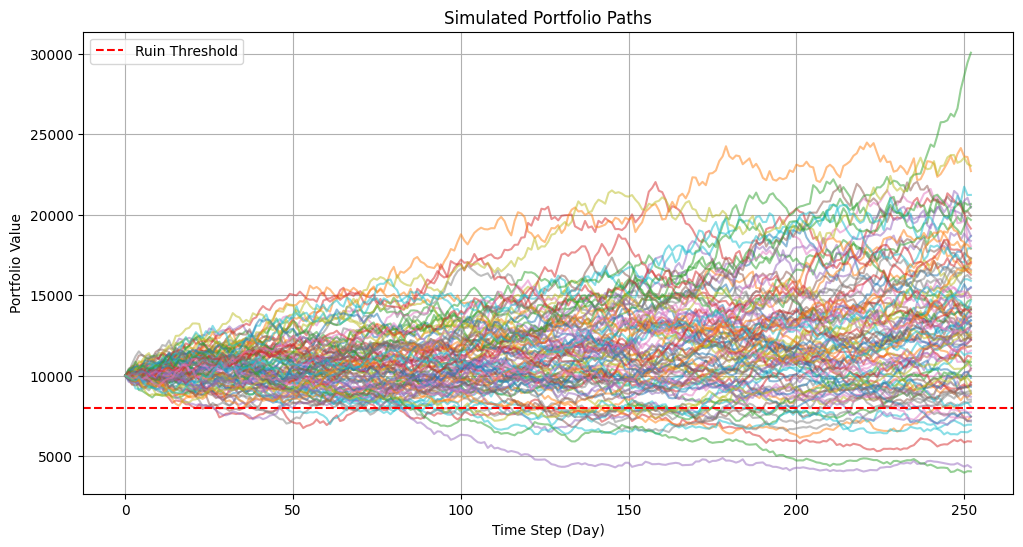

In [13]:
# Parameters
initial_value = 10000
mu = 0.001  # daily return ~0.1%
sigma = 0.02  # daily volatility ~2%
n_steps = 252  # 1 trading year
ruin_threshold = 0.8 # 20% drop
n_simulations = 500

# Run simulation
ruin_prob, paths = estimate_portfolio_ruin(initial_value, mu, sigma, ruin_threshold, n_steps, n_simulations)

# Display result
print(f"Estimated probability of ruin: {ruin_prob:.2%}")

# Plot some paths (first 100)
plt.figure(figsize=(12, 6))
for path in paths[:100]:
    plt.plot(path, alpha=0.5)
plt.axhline(ruin_threshold*initial_value, color='red', linestyle='--', label='Ruin Threshold')
plt.title("Simulated Portfolio Paths")
plt.xlabel("Time Step (Day)")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

So with an initial value of 10000, a mean daily return of 0.1% and a volatility of 2%. The probability that our portfolio's value drops by 20% in a trading year is around 23.4%.

But I wanted to make this more realistic, so we will use real financial data to simulate returns.

### Real Financial Data

We will replace the randomly generated return with historical daily returns of S&P 500 between 2019-01-01 and 2024-12-31

In [32]:
import yfinance as yf

def get_asset_returns(tickers, start, end):
  """
  This function returns the historical daily returns of a list of assets.

  Parameters:
  - tickers: a list of strings representing the ticker symbols of the assets
  - start: a string representing the start date in the format 'YYYY-MM-DD'
  - end: a string representing the end date in the format 'YYYY-MM-DD'

  Returns:
  - A pandas DataFrame with the historical daily returns of the assets.
  """
  data = yf.download(tickers, start=start, end=end)
  data.columns = data.columns.get_level_values(0)
  close_prices = data['Close'].dropna()
  returns = close_prices.pct_change().dropna()
  return returns

In [34]:
returns = get_asset_returns(['^GSPC'], '2019-01-01', '2024-12-31')

[*********************100%***********************]  1 of 1 completed


In [15]:
def simulate_portfolio_path_real_returns(initial_value, historical_returns, n_steps):
    sampled_returns = np.random.choice(historical_returns, size=n_steps, replace=True)
    values = [initial_value]
    for r in sampled_returns:
        values.append(values[-1] * (1 + r))
    return values

In [16]:
def estimate_real_portfolio_ruin(initial_value, historical_returns, threshold, n_steps, n_sims):
    c = 0
    paths = []
    ruin = threshold*initial_value
    for i in range(n_sims):
      v = simulate_portfolio_path_real_returns(initial_value, historical_returns, n_steps)
      paths.append(v)
      if np.any(np.array(v) < ruin):
        c += 1

    proba_ruin = c/n_sims
    return proba_ruin, paths

Estimated probability of ruin (real data): 10.80%


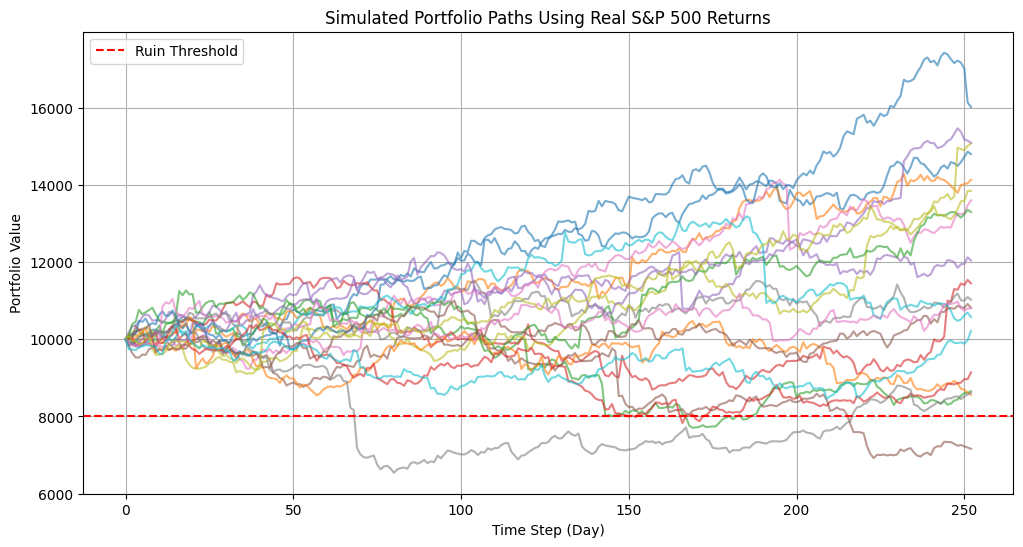

In [36]:
initial_value = 10000
ruin_threshold = 0.8
n_steps = 252
n_simulations = 500

ruin_prob, paths = estimate_real_portfolio_ruin(
    initial_value,
    returns.values,
    ruin_threshold,
    n_steps,
    n_simulations
    )

print(f"Estimated probability of ruin (real data): {ruin_prob:.2%}")

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for path in paths[:20]:
    plt.plot(path, alpha=0.6)
plt.axhline(ruin_threshold*initial_value, color='red', linestyle='--', label='Ruin Threshold')
plt.title("Simulated Portfolio Paths Using Real S&P 500 Returns")
plt.xlabel("Time Step (Day)")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.show()

With real data it's the ruin is further to reach. In general the ruin threshold it's not 80% of the initial value of the portfolio but more higher (usually the margin call is around 50% and a blow-up is 90-100% loss).
But we can consider that 80% is a required capital threshold in our case.

### Let's talk portfolio
Normally a portfolio doesn't contain a single index, but it's more multi-asset.

We now extend the ruin simulation to a real-world portfolio composed of multiple assets. By pulling historical return data from Yahoo Finance and computing weighted average returns using our custom function, we simulate how the portfolio evolves over time and estimate the likelihood of catastrophic losses.

In [37]:
tickers = ['AAPL', 'MSFT', 'GOOGL']
returns = get_asset_returns(tickers, '2019-01-01', '2024-12-31')

[*********************100%***********************]  3 of 3 completed


In [38]:
def portfolio_return(returns, weights):
    """
    The function compute the weighted average return of a protfolio, where each asset's return is multiplied by its portfolio weight.

    Parameters:
    - returns : the return of each asset
    - weights : the weight of each asset in the portfolio

    Returns:
    - the weighted average return of the portfolio
    """
    import numpy as np

    return np.dot(returns, weights/np.sum(weights))

In [41]:
weights = np.array([0.4, 0.3, 0.3])
daily_portfolio_returns = returns.apply(lambda r: portfolio_return(r.values, weights), axis=1)

Estimated probability of ruin (real data): 14.00%


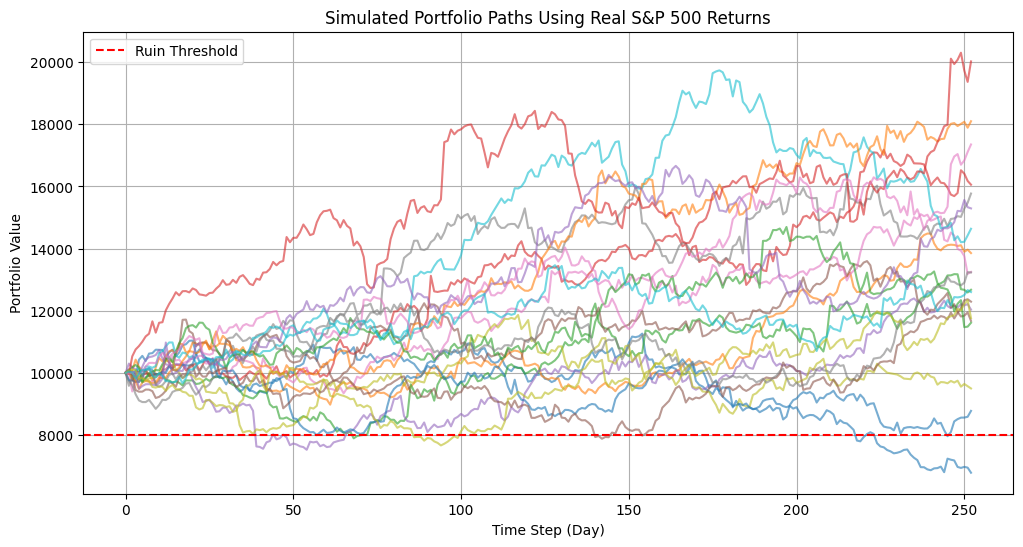

In [44]:
initial_value = 10000
ruin_threshold = 0.8
n_steps = 252
n_simulations = 500

ruin_prob, paths = estimate_real_portfolio_ruin(
    initial_value,
    daily_portfolio_returns.values,
    ruin_threshold,
    n_steps,
    n_simulations
    )

print(f"Estimated probability of ruin (real data): {ruin_prob:.2%}")

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for path in paths[:20]:
    plt.plot(path, alpha=0.6)
plt.axhline(ruin_threshold*initial_value, color='red', linestyle='--', label='Ruin Threshold')
plt.title("Simulated Portfolio Paths Using Real S&P 500 Returns")
plt.xlabel("Time Step (Day)")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.show()

### Real Portfolio Value

Now I want to compute how this portfolio would have performed historically, using real asset prices and fixed weights. This will gives me a more realistic baseline to compare against Monte Carlo simulations.


In [46]:
portfolio_value = (1 + daily_portfolio_returns).cumprod() * initial_value

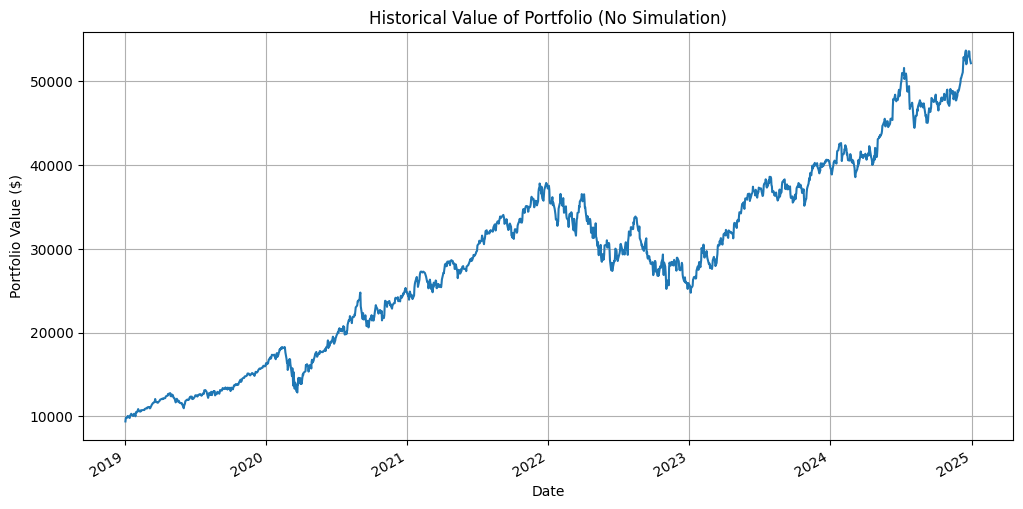

In [47]:
plt.figure(figsize=(12, 6))
portfolio_value.plot()
plt.title("Historical Value of Portfolio (No Simulation)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.show()

### Insights: Historical vs. Simulated Portfolio Performance

| Aspect                  | Historical Portfolio                   | Simulated Portfolio (1 Year Horizon)         |
|-------------------------|----------------------------------------|---------------------------------------------|
| **Time Horizon**        | 6+ years (2018–2025)                   | 252 trading days (1 year)                   |
| **Growth**              | Strong upward trend, ~5x increase      | Positive drift, flatter on average          |
| **Drawdowns**           | Realistic (e.g., 2020 crash)           | Some scenarios show steep drops             |
| **Ruin Risk (< \$8k)**  | Never occurred                         | Present in several paths                    |
| **Volatility**          | Time-varying, realistic                | Captured via historical return sampling     |
| **Interpretation**      | Robust past performance                | Non-zero probability of short-term ruin     |


### Final Thoughts: From Probability to Portfolios... to Paths

We began this notebook with a question inspired by **Gambler’s Ruin**:  
> *What’s the probability that a portfolio, starting at a certain value, eventually falls below a critical threshold?*

To explore this, we:

- Used **Monte Carlo simulations** to generate future paths based on actual return distributions.
- Introduced a **ruin threshold** and estimated the probability of hitting it.
- Analyzed real S&P 500 returns and built a historical portfolio value curve.


### Conclusion

> **Past performance doesn’t guarantee future safety.**  
Even well-performing portfolios carry downside risk, especially over short horizons.

**Monte Carlo simulations add realism**: by resampling actual returns, we account for:
- Daily volatility
- Fat-tailed distributions
- Realistic market downturns

This framework is foundational for:
- Value-at-Risk (VaR)
- Stress testing
- Portfolio optimization under uncertainty

---

### What’s Next: From Risk Paths to Graph Paths

In this notebook, we explored **portfolio paths over time** using probability theory.  
In the next one, we will explore **paths of a different nature** — the kind that appear in **graphs** and **networks**.

Inspired by the classic **Seven Bridges of Königsberg** problem, we will transition into **graph theory applied to finance**, including:

- Market networks
- Arbitrage loops
- Asset correlation graphs
- Liquidity flow structures
